<Axes: >

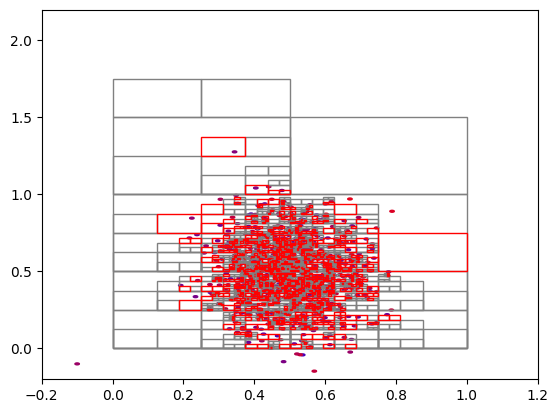

In [3]:
'''
This notebook is intended to make a prototype for the barnes huts algorithm.
'''

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches


def sigmoidColorMap(x:float,steepness:float,shift:float)->float:
    '''
    Basically map (0, inf) to (0, 1) using a sigmoid function.
    '''
    return 1 / (1 + np.exp(-1/steepness*(x-shift)))

class Particle:
    density:float = 1000
    def __init__(self, x:np.ndarray, v:np.ndarray, mass:float):
        self.x:np.ndarray = x
        self.v:np.ndarray = v
        self.F:np.ndarray = np.zeros(2)
        self.mass:float = mass
    
    @property
    def a(self)->np.ndarray:
        return self.F / self.mass
    @property
    def radius(self)->float:
        '''using the density of the particle to calculate the radius. assume 3D'''
        return (3/4/np.pi * self.mass / self.density)**(1/3)

    @property
    def color(self)->tuple:
        RED = np.array((1, 0, 0))
        BLUE = np.array((0, 0, 1))
        scale = sigmoidColorMap(np.linalg.norm(self.v), 10, 10)
        return tuple((RED*scale + (1-scale)*BLUE).tolist())


class Node:
    def __init__(self, position: np.ndarray, width: float, height:float):
        self.position:np.ndarray = position
        self.width:float = width
        self.height:float = height
        self.children:list[Node]=[None,None,None,None]
        self.particle:Particle = None

        halfWidth = width/2
        halfHeight = height/2
        self.OFFSETS = [np.array([0,0]),np.array([halfWidth,0]),np.array([0,halfHeight]),np.array([halfWidth,halfHeight])]
    
    def this(self,*args,**kwargs)->'Node':
        # calling constructor within self. 
        # Reason for this is to allow for easier inheritance
        # in subdivide, makes new Node, but when subclassed by GravitationalNode, it should return a GravitationalNode
        return self.__class__(*args,**kwargs)        

    @property
    def corners(self)->list[np.ndarray]:
        '''
        return a list of vectors representing the vertices
        '''
        return [self.position, self.position+np.array([self.width,0]), self.position+np.array([0,self.height]), self.position+np.array([self.width,self.height])]
    
    @property
    def leaves(self)->list['Node']:
        if self.particle is not None:
            return [self]
        
        return [leaf for child in self.children if child is not None for leaf in child.leaves] 
    @property
    def allChildren(self) -> list['Node']:
        if not any(self.children):  # No children exist
            return [self]

        res = [self]
        for child in self.children:
            if child is not None:
                res.extend(child.allChildren)  # Correct recursive call

        return res
    
    def insert(self,particle:Particle)->None:
        if self.isOutOfBounds(particle):
            return
        elif self.particle is None and not any(self.children):
            self.particle = particle
            return
        if self.particle is not None:
            self.subdivide()
            self.moveToChildren(self.particle)
            self.particle = None

        self.moveToChildren(particle)
    
    def subdivide(self):
        for i in range(4):
            if self.children[i] is None:
                self.children[i] = self.this(self.position+self.OFFSETS[i],self.width/2,self.height/2)

    def moveToChildren(self,particle:Particle):
        for child in self.children:
            if child is None:
                continue
            if child.isOutOfBounds(particle):
                continue
            child.insert(particle)
            break

    def isOutOfBounds(self,particle:Particle)->bool:
        return not (
                    (particle.x[0]>=self.position[0]) and
                    (particle.x[0]<self.position[0]+self.width) and
                    (particle.x[1]>= self.position[1]) and
                    (particle.x[1]<self.position[1]+self.height)
                )
    



particles = [ Particle(np.array([np.random.randn(),np.random.randn()*2])/10+np.array([0.5,0.5]), np.random.randn(2)*10, 0.001) for _ in range(1000) ]
outOfBoundsParticle = Particle(np.array([-0.1,-0.1]),np.array([10,10]),0.001)
particles.append(outOfBoundsParticle)

def plotParticles(particles):
    fig, ax = plt.subplots()
    ax.set_xlim(-0.2,1.2)
    ax.set_ylim(-0.2,2.2)
    for p in particles:
        ax.add_patch(patches.Circle(p.x, p.radius, color=p.color))
    return fig, ax

fig,ax = plotParticles(particles)

root = Node(np.array([0,0]),1,2)

for p in particles:
    root.insert(p)

def plotTree(node:Node,ax):
    leaves = node.leaves
    for child in node.allChildren:
        if child not in leaves:
            ax.add_patch(patches.Rectangle(child.position,child.width,child.width,fill=False,edgecolor='grey'))
    for leaf in leaves:
        ax.add_patch(patches.Rectangle(leaf.position,leaf.width,leaf.width,fill=False,edgecolor='red'))
    return ax

plotTree(root,ax)

In [4]:
from typing import override
from functools import lru_cache as lrucache

class GravitationalNode(Node):
    G: float = 6.67430e-11
    EPSILON: float = 1e-6 # Prevent division by zero

    def __init__(self, position: np.ndarray, width: float, height: float):
        super().__init__(position, width, height)
        self.children:list[GravitationalNode]
    
    def __repr__(self):
        return f'{self.position}, {self.width}, {self.height}, {self.mass}'
    
    @property
    @lrucache()
    def mass(self)->float:
        return (self.particle.mass if self.particle else 0)+sum(c.mass for c in self.children if c)
    
    @property
    @lrucache()
    def centerOfMass(self)->np.ndarray:
        total_mass = self.mass
        if total_mass == 0:
            return self.position
        weighted_sum = np.zeros(2,dtype = np.float64) + (self.particle.mass*self.particle.x if self.particle else np.zeros(2,dtype = np.float64))
        for c in self.children:
            if c:
                weighted_sum += c.mass*c.centerOfMass
        return weighted_sum / total_mass
    
    def approximate_force(self,particle:Particle,theta:float=0.9)->None:
        r = np.linalg.norm(self.centerOfMass - particle.x)+self.EPSILON
        
        if self.children == [None,None,None,None]:
            particle.F += self.G * self.mass * particle.mass / r**2 * (self.centerOfMass - particle.x) / r
        
        elif self.width/r < theta:
            particle.F += self.G * self.mass * particle.mass / r**2 * (self.centerOfMass - particle.x) / r
        else:
            for child in self.children:
                if child is not None:
                    if child.particle != particle:
                        child.approximate_force(particle,theta)
                        
    def apply_forces(self, particles: list[Particle], theta: float = 0.9):
        for particle in particles:
            self.approximate_force(particle, theta)

    


In [5]:
EPSILON = 1e-6
def apply_gravity(particles:list[Particle],algorithm:str = 'brute',**kwargs)->None:
    match algorithm:
        case 'brute':
            for i in range(len(particles)):
                for j in range(i+1,len(particles)):
                    p1 = particles[i]
                    p2 = particles[j]
                    r = np.linalg.norm(p1.x - p2.x) + EPSILON

                    force_magnitude = GravitationalNode.G * p1.mass * p2.mass / r**2
                    direction = (p2.x - p1.x) / r

                    p1.F += force_magnitude * direction
                    p2.F -= force_magnitude * direction
                    
        case 'barnes-hut':
            root_node:GravitationalNode = kwargs.pop('root_node',None)
            if root_node is None:
                raise ValueError('root_node must be provided for barnes-hut algorithm')
            root_node.apply_forces(particles,**kwargs)
        case _:
            raise NotImplementedError(f'Algorithm {algorithm} not implemented')

    

In [6]:
import pygame
import numpy as np
from copy import deepcopy
# from gravitational_node import GravitationalNode, Particle  # Assuming you've put the classes in a separate file

# Initialize Pygame
pygame.init()

# Set up display parameters
WIDTH, HEIGHT = 800, 600
screen = pygame.display.set_mode((WIDTH, HEIGHT),pygame.RESIZABLE)
pygame.display.set_caption("Gravity Simulation")
clock = pygame.time.Clock()
font = pygame.font.Font(None, 36)

# Set up colors
WHITE = (255, 255, 255)
BLACK = (0, 0, 0)
BLUE = (0, 0, 255)
RED = (255, 0, 0)

# Initialize root_node once outside the loop
root_node = GravitationalNode(position=np.array([0, 0]), width=WIDTH, height=HEIGHT)

centre = np.array([WIDTH / 2, HEIGHT / 2])
rawParticles = [Particle(np.random.randn(2) * min(WIDTH, HEIGHT) / 6 + centre, 0*np.random.randn(2) * 10, 1000000) for _ in range(100)]
particles = deepcopy(rawParticles)
# # Insert particles into the node once
# for p in particles:
#     root_node.insert(p)

# Main simulation loop 
running = True
while running:
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False

    # Clear screen
    screen.fill(WHITE)

    # Reset forces for each particle
    for p in particles:
        p.F = np.array([0.0,0.0])  # Reset forces

    # Insert particles into the node once
    root_node = GravitationalNode(position=np.array([0, 0]), width=screen.get_width(), height=screen.get_height())  
    for p in particles:
        root_node.insert(p)

    # apply gravity
    apply_gravity(particles, algorithm='barnes-hut', root_node=root_node, theta=1.0)
    # apply_gravity(particles, algorithm='brute', root_node=root_node)


    # Update particle positions based on forces
    for p in particles:
        p.v += p.a * 0.1  # Adjust timestep to a more reasonable value
        p.x += p.v * 0.1 # Adjust timestep to a more reasonable value
        # bounce off walls
        if p.x[0] < 0 or p.x[0] > screen.get_width():
            # make v absolutely negative if position is > screen width. make it positive if position is < 0
            p.v[0] = np.abs(p.v[0]) if p.x[0] < 0 else -np.abs(p.v[0])
        if p.x[1] < 0 or p.x[1] > screen.get_height():
            p.v[1] = np.abs(p.v[1]) if p.x[1] < 0 else -np.abs(p.v[1])

    # Draw the particles
    for p in particles:
        pygame.draw.circle(screen, p.color, (int(p.x[0]), int(p.x[1])), int(p.radius))

    # Draw the tree
    leaves = root_node.leaves
    for child in root_node.allChildren:
        if child not in leaves:
            # ax.add_patch(patches.Rectangle(child.position,child.width,child.width,fill=False,edgecolor='grey'))
            pygame.draw.rect(screen, BLACK, (*child.position, child.width, child.height), 1)
    for leaf in leaves:
        # ax.add_patch(patches.Rectangle(leaf.position,leaf.width,leaf.width,fill=False,edgecolor='red'))
        pygame.draw.rect(screen, RED, (*leaf.position, leaf.width, leaf.height), 1)


    # Calculate and display the FPS
    current_fps = clock.get_fps()  # Get FPS
    fps_text = font.render(f"FPS: {current_fps:.2f}", True, (0, 0, 0))
    screen.blit(fps_text, (10, 10))  # Display FPS on the screen
    print(current_fps, end='\r')

    # Refresh the display
    pygame.display.flip()
    
    # Control the frame rate
    clock.tick(60)  # 60 frames per second


# Quit Pygame
pygame.quit()


pygame 2.6.1 (SDL 2.28.4, Python 3.12.9)
Hello from the pygame community. https://www.pygame.org/contribute.html
